### Introduction
In the case of 'Unfair clauses' the data is retrieved using the 'datasets' library.

In [31]:
# Required imports

# Data processing
from datasets import load_dataset  
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

## Data cleaning

• Remove: capital letters, punctuation, numbers, stop words

• Stemming 

• Correct misspellings

• Parts of speech tagging

• Chunking (named entity recognition, compound term extraction)

In [8]:
# Retrieving data using load_dataset function
data = load_dataset("laugustyniak/abusive-clauses-pl")
print(data)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4284
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3453
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1519
    })
})


The data is divided into sets: train, test and validation.

In [9]:
# Transforming data to Pandas DataFrame
df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()
df_validation = data['validation'].to_pandas()

In [10]:
df_train.head(10)

,text,label
0,Wszelka korespondencja wysyłana przez Pożyczko...,0
1,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,0
2,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,0
3,Pożyczkobiorca zleca firmie Narodowy Fundusz P...,0
4,Od niespłaconej w terminie raty Pożyczkobiorca...,0
5,Pożyczkobiorca ma prawo wybrać inny sposób prz...,0
6,W przypadku braku spłaty pożyczki w terminie P...,0
7,Zabezpieczeniem spłaty pożyczki będzie podpisa...,0
8,Termin zwrotu pożyczki strony ustalają na 01 w...,0
9,"Okres trwania pożyczki wynosi 1 miesiąc, przy ...",0


In [11]:
print(df_train['text'][9])

Okres trwania pożyczki wynosi 1 miesiąc, przy czym może zostać przedłużana co miesiąc do 24 miesięcy


In the 'text' column there is text of agreement. In the 'label' (output) column there are two possible values: 0 in the case of abusive clause\, and 1 in the case of correct agreement statement

In [12]:
# Checking if there are any null values in the 'text' column of the train, test, or validation
print(df_train['text'].isnull().any() or df_test['text'].isnull().any() or df_validation['text'].isnull().any())

False


In [13]:
# Percentage of abusive clauses and correct agreement statements
print(round(df_train['label'].value_counts()/len(df_train['label']) * 100, 2))

label
1    54.58
0    45.42
Name: count, dtype: float64


In [14]:
# Calculating the length of each agreement
df_train['text_length'] = df_train['text'].apply(len)

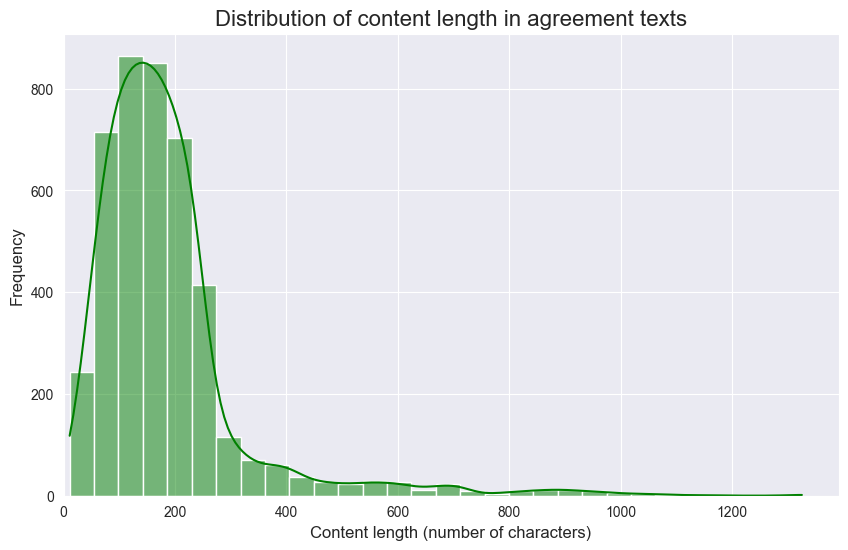

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], kde=True, bins=30, color='green')
plt.title('Distribution of content length in agreement texts', fontsize=16)
plt.xlabel('Content length (number of characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(left=0)
plt.show()

From the chart it can be concluded that most of the content of the agreements does not exceed 200 characters.

## 2. Data preprocessing

short description

In [16]:
df_train['text'].iloc[9]

'Okres trwania pożyczki wynosi 1 miesiąc, przy czym może zostać przedłużana co miesiąc do 24 miesięcy'

In [17]:
# Removing numbers from the text using regex pattern
pattern = r'\b\w*\d\w*\b'
df_train['text'] = df_train['text'].str.replace(pattern, '', regex=True).str.strip()
df_train['text'].iloc[9]

'Okres trwania pożyczki wynosi  miesiąc, przy czym może zostać przedłużana co miesiąc do  miesięcy'

In [18]:
# Removing capital letters from the content
df_train['text'] = df_train['text'].str.lower()
df_train['text'].iloc[9]

'okres trwania pożyczki wynosi  miesiąc, przy czym może zostać przedłużana co miesiąc do  miesięcy'

In [19]:
# Removing punctuation marks from the content
df_train['text'] = df_train['text'].str.replace(r'[^\w\s]','',regex=True)
df_train['text'].iloc[9]

'okres trwania pożyczki wynosi  miesiąc przy czym może zostać przedłużana co miesiąc do  miesięcy'

In [20]:
# Data preprocessing for test and validation data sets
df_test['text'] = df_test['text'].str.replace(pattern, '', regex=True).str.strip()
df_test['text'] = df_test['text'].str.lower()
df_test['text'] = df_test['text'].str.replace(r'[^\w\s]','',regex=True)

df_validation['text'] = df_validation['text'].str.replace(pattern, '', regex=True).str.strip()
df_validation['text'] = df_validation['text'].str.lower()
df_validation['text'] = df_validation['text'].str.replace(r'[^\w\s]','',regex=True)

## Machine learning

In [21]:
x_train = df_train.text
x_test = df_test.text

In [22]:
y_train = df_train.label
y_test = df_test.label

There are no polish stop words in nltk library, so I manually added txt file with them

In [23]:
# Loading stop words from a file
with open("polish.stopwords.txt", "r", encoding="utf-8") as f:
    polish_stop_words = [line.strip() for line in f]

In [ ]:
cv = CountVectorizer(stop_words=polish_stop_words)
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

In [36]:
cv_tfidf = TfidfVectorizer(stop_words=polish_stop_words)
x_train_cv_tfidf = cv_tfidf.fit_transform(x_train)
x_test_cv_tfidf = cv_tfidf.transform(x_test)

### Linear regression

In [25]:
# Linear regression ob
lr = LogisticRegression()
lr.fit(x_train_cv, y_train)
y_pred_cv = lr.predict(x_test_cv)

LogisticRegression()

In [29]:
cm = confusion_matrix(y_test, y_pred_cv)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.801
Precision: 0.854
Recall: 0.851
F1 Score: 0.852


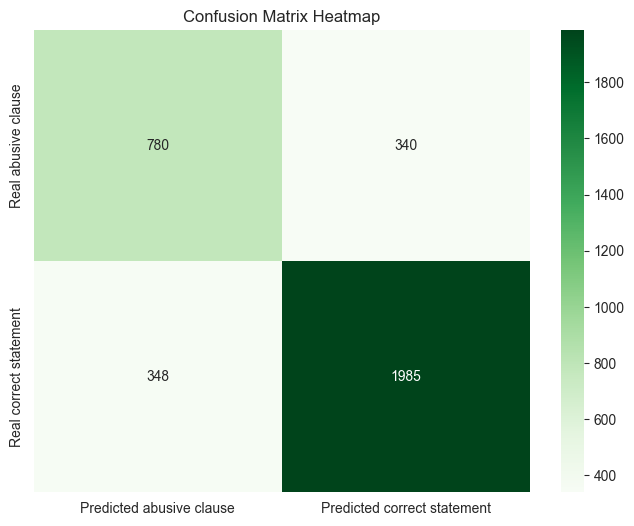

In [30]:
plt.figure(figsize=(8, 6))
true_labels = ['Real abusive clause', 'Real correct statement']
predicted_labels = ['Predicted abusive clause', 'Predicted correct statement']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=predicted_labels, yticklabels=true_labels)
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
# Logistic regression with TF-IDF vectorizer
lr2 = LogisticRegression()
lr2.fit(x_train_cv_tfidf, y_train)
y_pred_tfidf = lr2.predict(x_test_cv_tfidf)

In [38]:
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.796
Precision: 0.837
Recall: 0.866
F1 Score: 0.851


### Naive bayes

In [32]:
nb = MultinomialNB()
nb.fit(x_train_cv, y_train)

MultinomialNB()

In [33]:
y_pred_cv_nb = nb.predict(x_test_cv)

In [34]:
cm = confusion_matrix(y_test, y_pred_cv_nb)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.776
Precision: 0.868
Recall: 0.788
F1 Score: 0.826


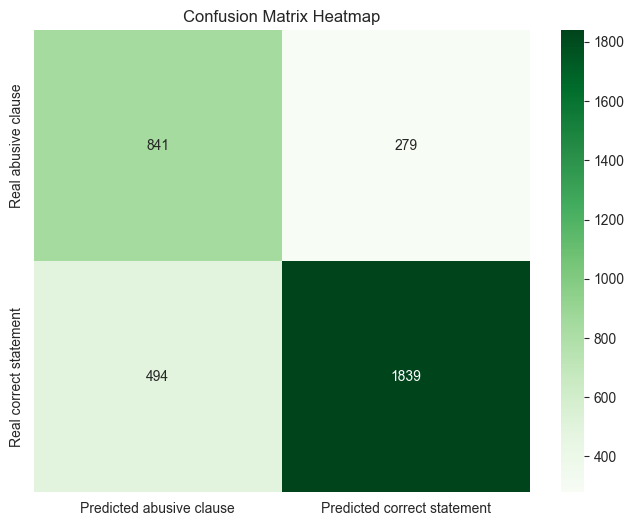

In [35]:
plt.figure(figsize=(8, 6))
true_labels = ['Real abusive clause', 'Real correct statement']
predicted_labels = ['Predicted abusive clause', 'Predicted correct statement']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=predicted_labels, yticklabels=true_labels)
plt.title('Confusion Matrix Heatmap')
plt.show()